# The battle of neighborhood

#### 11-Aug-2020

## This project is the final project for the course "Applied data science capstone". 

### The objective:
Singapore, which is a city state where I live.
Japanese cuisine is my favorite food.

I will use the foursquare API to explore the venues in each neighborhood in Singapore, figure out answer for following questions:

1. which neighborhood have more Japanese restaurants?
2. where are the best rated Japanese restaurants in Singapore?
3. which neighborhood could be the best one if I would like to open a Japanese restaurant?
4. which neighborhood should I stay in order to visit nearest Japanese restaurant?

### Steps:

1. get the neighborhood information
2. create map visualize all neighborhood
3. cluster the neighborhood
4. select the neighborhood in the cluster that have Japanese restaurant for analysis
5. create dataframe that might present the answers for the questions listed above

#### Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import pandas as pd
import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c conda-forge lxml --yes #install lxml library for processing XML and HTML in the Python language

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


In [2]:
#!conda install -c anaconda beautifulsoup4 --yes

#print('Libraries imported.')


#### Download and Explore Dataset

Singapore has 28 postal districts, and each includes two or three neighborhoods, this information is presented in the table in webpage: https://en.wikipedia.org/wiki/Postal_codes_in_Singapore

following script code creates the data frame includes all neighbourhood name, longtitude and lagtitude.

In [3]:
sg_pc = pd.read_html('https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm')[0] #more than one table in the page, we choose the first one that we need
sg_pc = sg_pc.loc[1:,:]
sg_pc.columns = ['Postal_District', 'Postal_Sector','General_Location']
sg_pc.drop('Postal_Sector',1)
sg_df = pd.DataFrame(sg_pc.General_Location.str.split(', ').tolist(), index=sg_pc.Postal_District).stack()
sg_df = sg_df.reset_index([0, 'Postal_District'])
sg_df.columns = ['Postal_District', 'Neighborhood']
sg_df.head()

,Postal_District,Neighborhood
0,01,Raffles Place
1,01,Cecil
2,01,Marina
3,01,People's Park
4,02,Anson


In [4]:
#sg_df['Latitude']=0
#sg_df['Longitude']=0
#sg_df.head()
for index, neighbor in enumerate(sg_df['Neighborhood']):
    address = str(neighbor+", Singapore")
    #print(address)
    #print(index)
    geolocator = Nominatim(user_agent="SG_explorer")
    try:
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        #print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))
        sg_df.loc[index,'Latitude'] = latitude
        sg_df.loc[index,'Longtitude'] = longitude
    except:
        latitude = 'NaN'
        longtitude = 'NaN'
        sg_df.loc[index,'Latitude'] = latitude
        sg_df.loc[index,'Longtitude'] = longitude
sg_df.head()
print(sg_df.shape)

(68, 4)


It is found that there are geolocator is not able to define the latitude for two neighborhood in the list, temporarily remvoe them from this analysis

In [5]:
sg_df =sg_df[sg_df.Latitude != 'NaN']
print(sg_df.shape)
sg_df.head()

(66, 4)


,Postal_District,Neighborhood,Latitude,Longtitude
0,01,Raffles Place,1.28354,103.851460
1,01,Cecil,1.27696,103.847016
2,01,Marina,1.29048,103.852036
3,01,People's Park,1.28581,103.844160
4,02,Anson,1.27663,103.847247


Use geopy library to get the latitude and longitude values of Toronto

In [6]:
address = 'Singapore'

geolocator = Nominatim(user_agent="SG_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore are 1.3408630000000001, 103.83039182212079.


Create a map of Toronto with neighborhoods in East Toronto, West Toronto, Central Toronto, Downtown Toronto superimposed on top.

In [7]:
# create map of New York using latitude and longitude values
map_singapore = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(sg_df['Latitude'], sg_df['Longtitude'], sg_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)  
    
map_singapore

Define Foursquare Credentials and Version

In [8]:
CLIENT_ID = 'FUKWOS2ZEACUPVZEYA05FKRQVYTYX0F1GC2NP5LHWTXOF3QH' # your Foursquare ID
CLIENT_SECRET = 'W0HWJ3G0ZE2JL1LBQNJ0YLKHMYIAI0JZP12CNIMOZVYBI4BW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FUKWOS2ZEACUPVZEYA05FKRQVYTYX0F1GC2NP5LHWTXOF3QH
CLIENT_SECRET:W0HWJ3G0ZE2JL1LBQNJ0YLKHMYIAI0JZP12CNIMOZVYBI4BW


Explore Neighborhoods

In [9]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            
            
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood_Latitude', 
                             'Neighborhood_Longitude', 
                             'Venue',
                             'ID',
                             
                             'Venue_Latitude', 
                             'Venue_Longitude', 
                             'Venue_Category']
    
    return(nearby_venues)

sg_venues = getNearbyVenues(names=sg_df['Neighborhood'],
                                   latitudes=sg_df['Latitude'],
                                   longitudes=sg_df['Longtitude']
                                  )        


Raffles  Place
Cecil
Marina
People's Park
Anson
 Tanjong Pagar
Queenstown
 Tiong Bahru
Telok  Blangah
Harbourfront
Pasir  Panjang
Clementi New Town
High  Street
Middle  Road
Golden Mile
Little  India
Orchard
 Cairnhill
River Valley
Ardmore
 Bukit Timah
Holland Road
Tanglin
Watten  Estate
Novena
Thomson
Balestier
 Toa Payoh
Serangoon
Macpherson
 Braddell
Geylang
 Eunos
Katong
 Joo Chiat
Amber Road
Bedok
 Upper East Coast
Eastwood
Kew Drive
Loyang
 Changi
Tampines
 Pasir Ris
Serangoon  Garden
Hougang
Ponggol
Bishan
 Ang Mo Kio
Upper  Bukit Timah
Clementi Park
Ulu Pandan
Jurong
Hillview
 Dairy Farm
Bukit Panjang
Choa Chu Kang
Lim  Chu Kang
Tengah
Kranji
 Woodgrove
Upper  Thomson
Springleaf
Yishun
 Sembawang
Seletar


In [10]:
sg_venues.head()

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,ID,Venue_Latitude,Venue_Longitude,Venue_Category
0,Raffles Place,1.283542,103.85146,The Fullerton Bay Hotel,4e3ce52ce4cdab9b933c525f,1.283878,103.853314,Hotel
1,Raffles Place,1.283542,103.85146,City Hot Pot,53ae48b4498ec970f3cc0455,1.284173,103.851585,Hotpot Restaurant
2,Raffles Place,1.283542,103.85146,Virgin Active,525699bf498e6701439cb8df,1.284608,103.850815,Gym / Fitness Center
3,Raffles Place,1.283542,103.85146,CULINARYON,55fe3da6498e0c5eaa442250,1.284876,103.850933,Comfort Food Restaurant
4,Raffles Place,1.283542,103.85146,1-Altitude,4c419bceff711b8d2c281205,1.284794,103.851151,Cocktail Bar


In [11]:
sg_venues.shape

(2644, 8)

Display how many venues were returned for each neighborhood

In [12]:
sg_venues.groupby('Neighborhood').count()

,Neighborhood_Latitude,Neighborhood_Longitude,Venue,ID,Venue_Latitude,Venue_Longitude,Venue_Category
Neighborhood,,,,,,,
Ang Mo Kio,41,41,41,41,41,41,41
Braddell,39,39,39,39,39,39,39
Bukit Timah,12,12,12,12,12,12,12
Cairnhill,10,10,10,10,10,10,10
Changi,6,6,6,6,6,6,6
Dairy Farm,10,10,10,10,10,10,10
Eunos,20,20,20,20,20,20,20
Joo Chiat,11,11,11,11,11,11,11
Pasir Ris,44,44,44,44,44,44,44


apply one hot encoding to the category of the venues

In [13]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_venues[['Venue_Category']], prefix="", prefix_sep="")
sg_onehot.drop(['Neighborhood'],axis=1,inplace=True) 
sg_onehot.insert(loc=0, column='Neighborhood', value=sg_venues['Neighborhood'] )
print(sg_onehot.shape)
sg_onehot.head()

(2644, 252)


,Neighborhood,Airport,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Campground,Canal,Candy Store,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Farm,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Hill,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lighthouse,Lighting Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mosque,Motel,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Parking,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Playground,Plaza,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Raffles Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Group by the neighborhood

In [14]:
sg_grouped = sg_onehot.groupby('Neighborhood').mean().reset_index()
sg_grouped.head()

,Neighborhood,Airport,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Campground,Canal,Candy Store,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Farm,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Hill,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lighthouse,Lighting Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mosque,Motel,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Parking,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Playground,Plaza,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Ang Mo Kio,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.024390,0.0,0.0,0.000000,0.0,0.024390,0.02439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.04878,0.0,0.0,0.02439,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.024390,0.0,0.0,0.0,0.0,0.0,0.0,0.097561,0.0,0.0,0.024390,0.0,0.0,0.0,0.0,0.0,0.073171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [15]:
sg_grouped.shape

(63, 252)

Create a new dataframe that contains the most common venues in the neighborhood

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sg_grouped['Neighborhood']

for ind in np.arange(sg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ang Mo Kio,Coffee Shop,Dessert Shop,Bubble Tea Shop,Japanese Restaurant,Supermarket,Fast Food Restaurant,Snack Place,Food Court,Malay Restaurant,Noodle House
1,Braddell,Noodle House,Chinese Restaurant,Café,Food Court,Hakka Restaurant,Thai Restaurant,Bakery,Asian Restaurant,Seafood Restaurant,Breakfast Spot
2,Bukit Timah,Trail,Scenic Lookout,Rest Area,Hill,Zoo Exhibit,Food Court,Flower Shop,Food,Food & Drink Shop,Food Service
3,Cairnhill,Hotel,Wine Bar,Chinese Restaurant,Filipino Restaurant,Women's Store,Pub,Other Great Outdoors,Food Court,Flower Shop,Food
4,Changi,Airport,Office,Airport Terminal,Hotel,Rest Area,Food,Food & Drink Shop,Food Court,Food Service,Food Stand
5,Dairy Farm,Trail,Public Art,Rest Area,Parking,Bike Trail,Nature Preserve,Pool,Gym,Fried Chicken Joint,French Restaurant
6,Eunos,Chinese Restaurant,Basketball Court,Noodle House,Coffee Shop,Vegetarian / Vegan Restaurant,Arts & Crafts Store,Asian Restaurant,Bubble Tea Shop,Seafood Restaurant,Food Court
7,Joo Chiat,Seafood Restaurant,Noodle House,Chinese Restaurant,Bar,Food Court,Coffee Shop,Malay Restaurant,Gas Station,Arts & Crafts Store,Juice Bar
8,Pasir Ris,Food Court,Bus Station,Salon / Barbershop,Park,Fast Food Restaurant,Coffee Shop,Gym,Italian Restaurant,Supermarket,Sandwich Place
9,Sembawang,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Supermarket,Bus Line,Sporting Goods Shop,Japanese Restaurant,Bus Stop,Electronics Store,Basketball Court


Making Clusters for Neighborhood

In [18]:
# set number of clusters
kclusters = 5

sg_grouped_clustering = sg_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 4, 0, 3, 4, 0, 0, 0, 0], dtype=int32)

In [19]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
sg_merged = sg_df
# merge sg_grouped with SG_data to add latitude/longitude for each neighborhood
sg_merged = sg_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), how = 'inner',on='Neighborhood')
sg_merged.head()

,Postal_District,Neighborhood,Latitude,Longtitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,01,Raffles Place,1.28354,103.851460,0,Japanese Restaurant,Hotel,Chinese Restaurant,Gym / Fitness Center,Sandwich Place,Coffee Shop,Seafood Restaurant,French Restaurant,Food Court,Lounge
1,01,Cecil,1.27696,103.847016,0,Coffee Shop,Japanese Restaurant,Hotel,Bakery,Café,Bar,Ramen Restaurant,Korean Restaurant,Gym / Fitness Center,Italian Restaurant
2,01,Marina,1.29048,103.852036,0,Hotel,Concert Hall,Shopping Mall,Café,Italian Restaurant,Restaurant,Cocktail Bar,Coffee Shop,Bakery,Cantonese Restaurant
3,01,People's Park,1.28581,103.844160,0,Food Court,Chinese Restaurant,Hostel,Vegetarian / Vegan Restaurant,Hotel,BBQ Joint,Spa,Japanese Restaurant,Thai Restaurant,Noodle House
4,02,Anson,1.27663,103.847247,0,Coffee Shop,Japanese Restaurant,Hotel,Café,Bakery,Bar,Ramen Restaurant,Cocktail Bar,Gym / Fitness Center,Noodle House


Visualize the resulting clusters

In [20]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['Latitude'], sg_merged['Longtitude'], sg_merged['Neighborhood'], sg_merged['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examine Clusters

Cluster 1

In [21]:
sg_merged.loc[sg_merged['Cluster Labels'] == 0, sg_merged.columns[[1] + list(range(5, sg_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Raffles Place,Japanese Restaurant,Hotel,Chinese Restaurant,Gym / Fitness Center,Sandwich Place,Coffee Shop,Seafood Restaurant,French Restaurant,Food Court,Lounge
1,Cecil,Coffee Shop,Japanese Restaurant,Hotel,Bakery,Café,Bar,Ramen Restaurant,Korean Restaurant,Gym / Fitness Center,Italian Restaurant
2,Marina,Hotel,Concert Hall,Shopping Mall,Café,Italian Restaurant,Restaurant,Cocktail Bar,Coffee Shop,Bakery,Cantonese Restaurant
3,People's Park,Food Court,Chinese Restaurant,Hostel,Vegetarian / Vegan Restaurant,Hotel,BBQ Joint,Spa,Japanese Restaurant,Thai Restaurant,Noodle House
4,Anson,Coffee Shop,Japanese Restaurant,Hotel,Café,Bakery,Bar,Ramen Restaurant,Cocktail Bar,Gym / Fitness Center,Noodle House
5,Tanjong Pagar,Japanese Restaurant,Coffee Shop,Italian Restaurant,Hotel,Gym / Fitness Center,Café,Ramen Restaurant,Bakery,Asian Restaurant,Spanish Restaurant
6,Queenstown,Food Court,Chinese Restaurant,Noodle House,Vegetarian / Vegan Restaurant,Stadium,Steakhouse,Café,Coffee Shop,Train Station,Seafood Restaurant
7,Tiong Bahru,Chinese Restaurant,Coffee Shop,Café,Japanese Restaurant,Noodle House,Food Court,Bakery,Sushi Restaurant,Electronics Store,Fast Food Restaurant
8,Telok Blangah,Food Court,Coffee Shop,Golf Course,Breakfast Spot,Metro Station,Chinese Restaurant,Supermarket,Board Shop,Noodle House,Gym
9,Harbourfront,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Toy / Game Store,Clothing Store,Multiplex,Coffee Shop,Bakery,Korean Restaurant,Spa


Cluster 2

In [22]:
sg_merged.loc[sg_merged['Cluster Labels'] == 1, sg_merged.columns[[1] + list(range(5, sg_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
59,Lim Chu Kang,Zoo Exhibit,Farm,Flower Shop,Garden,Gaming Cafe,Furniture / Home Store,Fujian Restaurant,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint


In [23]:
sg_merged.loc[sg_merged['Cluster Labels'] == 2, sg_merged.columns[[1] + list(range(5, sg_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Little India,Indian Restaurant,Vegetarian / Vegan Restaurant,Hotel,Music Venue,Shopping Mall,Food,Rock Club,Bakery,Coffee Shop,Restaurant


In [24]:
sg_merged.loc[sg_merged['Cluster Labels'] == 3, sg_merged.columns[[1] + list(range(5, sg_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Changi,Airport,Office,Airport Terminal,Hotel,Rest Area,Food,Food & Drink Shop,Food Court,Food Service,Food Stand


In [25]:
sg_merged.loc[sg_merged['Cluster Labels'] == 4, sg_merged.columns[[1] + list(range(5, sg_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Bukit Timah,Trail,Scenic Lookout,Rest Area,Hill,Zoo Exhibit,Food Court,Flower Shop,Food,Food & Drink Shop,Food Service
56,Dairy Farm,Trail,Public Art,Rest Area,Parking,Bike Trail,Nature Preserve,Pool,Gym,Fried Chicken Joint,French Restaurant


### The neighborhood under study belong to cluster label = 0
Create a new dataframe that contains all the venues in neighborhood in cluster 3

In [26]:
temp = sg_merged[sg_merged['Cluster Labels']==0][['Neighborhood','Cluster Labels']]
df_jr=pd.merge(sg_venues,temp,how='right',on = 'Neighborhood')
df_jr = df_jr[df_jr['Venue_Category']=='Japanese Restaurant']
df_jr.shape

(104, 9)

In [27]:
df_jr.head()

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,ID,Venue_Latitude,Venue_Longitude,Venue_Category,Cluster Labels
17,Raffles Place,1.283542,103.85146,Healthy Soba IKI,542398b8498e93b780ef0289,1.284242,103.851490,Japanese Restaurant,0
25,Raffles Place,1.283542,103.85146,Jin Fine Dining,54119564498e4371f8dce458,1.283072,103.848744,Japanese Restaurant,0
46,Raffles Place,1.283542,103.85146,Kinki Restaurant & Bar,4bb0956af964a520814d3ce3,1.282562,103.853665,Japanese Restaurant,0
53,Raffles Place,1.283542,103.85146,BOTAN Japanese Restaurant Pte Ltd,4d5299d2e02754811353b6b6,1.283693,103.848553,Japanese Restaurant,0
74,Raffles Place,1.283542,103.85146,Koji Sushi Bar,5462d934498ebf35eb104b62,1.284441,103.847052,Japanese Restaurant,0


In [28]:
df_jr.groupby('Neighborhood').count().sort_values(by = 'Venue',ascending = False).head(5)

,Neighborhood_Latitude,Neighborhood_Longitude,Venue,ID,Venue_Latitude,Venue_Longitude,Venue_Category,Cluster Labels
Neighborhood,,,,,,,,
Tanjong Pagar,11,11,11,11,11,11,11,11
Anson,8,8,8,8,8,8,8,8
Cecil,8,8,8,8,8,8,8,8
Raffles Place,6,6,6,6,6,6,6,6
Middle Road,6,6,6,6,6,6,6,6


Plot the number of Japanese restaurant in each neighborhood

Text(0.5, 1.0, 'Number of Japanese restaurant in each neighborhood')

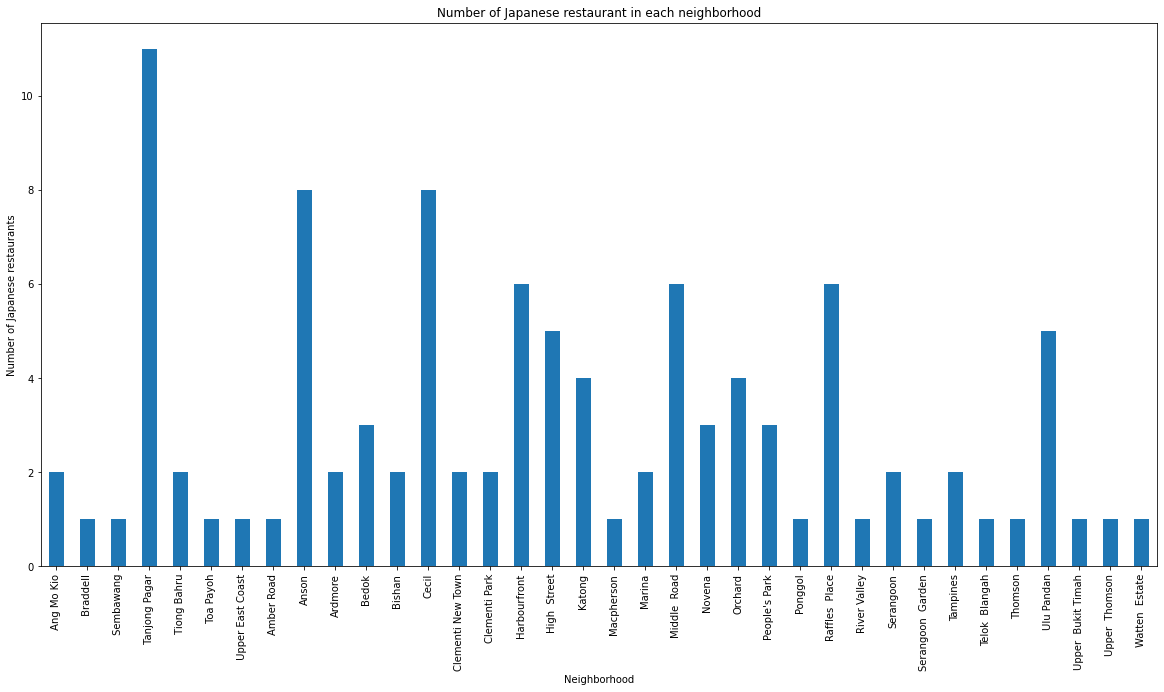

In [29]:
import matplotlib as plt
ax=df_jr.groupby('Neighborhood')['Venue'].count().plot(kind='bar',figsize = [20,10])
ax.set_ylabel('Number of Japanese restaurants')
ax.set_title('Number of Japanese restaurant in each neighborhood')

Create a new function that get the venue with details include the rating and tips

In [30]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'FUKWOS2ZEACUPVZEYA05FKRQVYTYX0F1GC2NP5LHWTXOF3QH' # your Foursquare ID
    CLIENT_SECRET = 'W0HWJ3G0ZE2JL1LBQNJ0YLKHMYIAI0JZP12CNIMOZVYBI4BW' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    
    # get all the data
    result = requests.get(url).json()
    venue_details=[]
    try:
        venue_id=result['response']['venue']['id']
        venue_name=result['response']['venue']['name']
        venue_likes = result['response']['venue']['likes']['count']
        venue_tips = result['response']['venue']['tips']['count']
        venue_rating=result['response']['venue']['rating']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [31]:
column_names=['ID','Name','Likes','Rating','Tips']
japan_rest_stats_sg=pd.DataFrame(columns=column_names)

for row in df_jr.values.tolist():
    Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude, Venue,ID,Venue_Latitude,Venue_Longitude,Venue_Category,Cluster_Labels=row
    try:
        venue_details=get_venue_details(ID)
        #print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        #print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    
    japan_rest_stats_sg = japan_rest_stats_sg.append({
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)

save the venue dataframe to a csv

In [32]:
#japan_rest_stats_sg.to_csv('japan_rest_stats_sg.csv')

In [33]:
japan_rest_stats_sg=pd.read_csv('japan_rest_stats_sg.csv')

In [34]:
japan_rest_stats_sg.drop('Unnamed: 0',1,inplace=True)
japan_rest_stats_sg.head()
japan_rest_stats_sg.shape

(104, 5)

In [35]:
japan_rest_stats_sg = japan_rest_stats_sg.merge(df_jr[['Neighborhood','ID','Venue_Latitude','Venue_Longitude','Venue_Category']],how='left', on='ID')
japan_rest_stats_sg.drop_duplicates(subset=['ID'],inplace=True)
japan_rest_stats_sg.head(5)
japan_rest_stats_sg.shape

(82, 9)

In [36]:
japan_rest_stats_sg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 0 to 159
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               82 non-null     object 
 1   Name             82 non-null     object 
 2   Likes            82 non-null     int64  
 3   Rating           82 non-null     float64
 4   Tips             82 non-null     int64  
 5   Neighborhood     81 non-null     object 
 6   Venue_Latitude   81 non-null     float64
 7   Venue_Longitude  81 non-null     float64
 8   Venue_Category   81 non-null     object 
dtypes: float64(3), int64(2), object(4)
memory usage: 6.4+ KB


In [37]:
japan_rest_stats_sg['Tips']=japan_rest_stats_sg['Tips'].astype('float64')
japan_rest_stats_sg['Likes']=japan_rest_stats_sg['Likes'].astype('float64')
japan_rest_stats_sg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 0 to 159
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               82 non-null     object 
 1   Name             82 non-null     object 
 2   Likes            82 non-null     float64
 3   Rating           82 non-null     float64
 4   Tips             82 non-null     float64
 5   Neighborhood     81 non-null     object 
 6   Venue_Latitude   81 non-null     float64
 7   Venue_Longitude  81 non-null     float64
 8   Venue_Category   81 non-null     object 
dtypes: float64(5), object(4)
memory usage: 6.4+ KB


Best Japanese restaurant according to the rating are shown below

In [38]:
best_jr=japan_rest_stats_sg.sort_values('Rating',ascending=False).head(5)
best_jr

,ID,Name,Likes,Rating,Tips,Neighborhood,Venue_Latitude,Venue_Longitude,Venue_Category
25,553b2460498e8cfc0a3cdc32,Yen Yakiniku,17.0,8.9,7.0,Cecil,1.281074,103.845743,Japanese Restaurant
114,4c079d410ed3c9286abe797d,Nanbantei Japanese Restaurant,75.0,8.9,41.0,Orchard,1.307124,103.833250,Japanese Restaurant
106,5d56a14d0ae78d000727add8,Una Una,4.0,8.8,3.0,Middle Road,1.299518,103.854266,Japanese Restaurant
36,5236ef9011d2a88886b4a0f9,Shinzo Japanese Cuisine,43.0,8.5,25.0,People's Park,1.288237,103.847677,Japanese Restaurant
108,4c56aea26418a593c7877d0e,Shinji by Kanesaka,68.0,8.4,33.0,Middle Road,1.295863,103.852708,Japanese Restaurant


Following present the neighborhood which has most number of Japanese restaurants

In [39]:
top_number_japan_restaurant_neighborhood=japan_rest_stats_sg.groupby('Neighborhood',as_index=False).count()
top_number_japan_restaurant_neighborhood=top_number_japan_restaurant_neighborhood.sort_values('ID',ascending=False)[['Neighborhood','ID']]
top_number_japan_restaurant_neighborhood.columns=['Neighborhood','Number of Japanese restaurant in neighborhood']
top_number_japan_restaurant_neighborhood.head()


,Neighborhood,Number of Japanese restaurant in neighborhood
12,Cecil,8
23,Raffles Place,6
18,Middle Road,6
14,Harbourfront,6
30,Ulu Pandan,5


<AxesSubplot:xlabel='Neighborhood'>

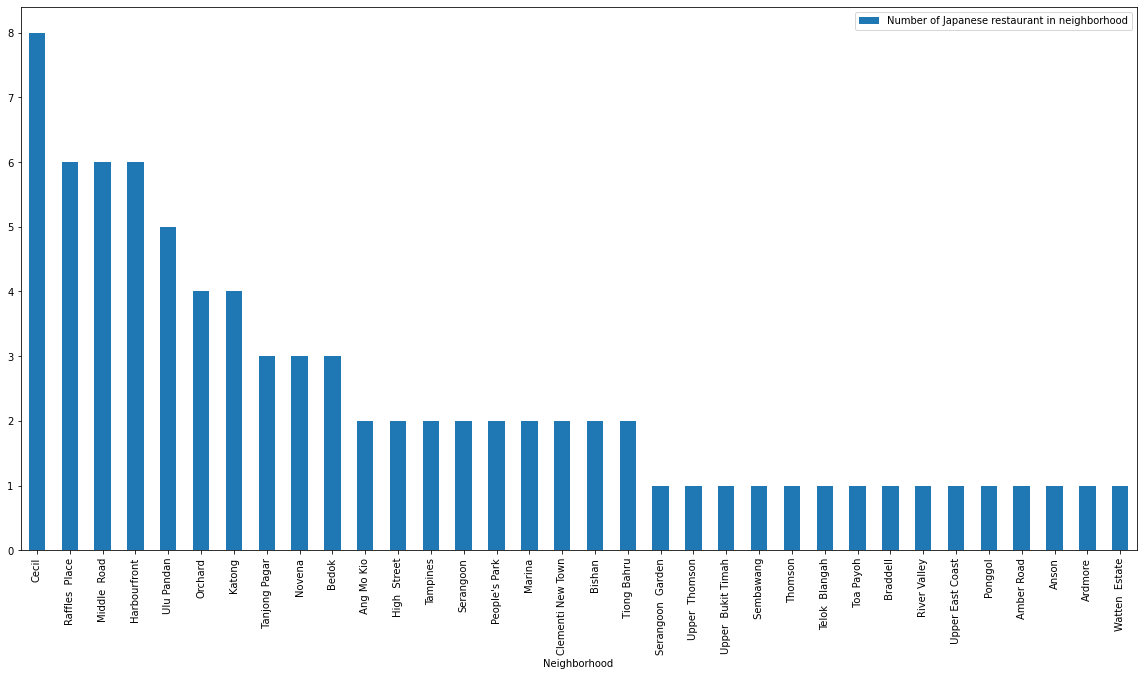

In [40]:
top_number_japan_restaurant_neighborhood.plot('Neighborhood','Number of Japanese restaurant in neighborhood',kind='bar',figsize=[20,10])

In [41]:
japan_rest_stats_sg.groupby('Neighborhood',as_index=False).mean().sort_values('Rating',ascending=False)

,Neighborhood,Likes,Rating,Tips,Venue_Latitude,Venue_Longitude
20,Orchard,57.000000,8.050000,32.500000,1.305690,103.831020
12,Cecil,35.875000,8.037500,19.250000,1.277829,103.845521
9,Ardmore,49.000000,8.000000,43.000000,1.306842,103.827266
15,High Street,11.500000,8.000000,5.500000,1.286357,103.848834
21,People's Park,26.000000,7.850000,14.000000,1.287022,103.846211
18,Middle Road,33.500000,7.816667,26.833333,1.297991,103.852891
4,Tiong Bahru,38.000000,7.750000,17.500000,1.283200,103.828243
23,Raffles Place,43.666667,7.716667,23.000000,1.283280,103.849536
8,Anson,63.000000,7.700000,31.000000,1.274432,103.843812
17,Marina,31.000000,7.700000,14.500000,1.290800,103.851431


In [42]:
temp = japan_rest_stats_sg.groupby('Neighborhood',as_index=False).count().sort_values('Rating',ascending=False)[['Neighborhood','ID']]
temp.columns=['Neighborhood','Number of Japanese Restaurant']
temp.head()

,Neighborhood,Number of Japanese Restaurant
12,Cecil,8
23,Raffles Place,6
18,Middle Road,6
14,Harbourfront,6
30,Ulu Pandan,5


In [43]:
japan_rest_stats_sg=pd.merge(japan_rest_stats_sg.groupby('Neighborhood',as_index=False).mean().sort_values('Rating',ascending=False),temp,on='Neighborhood')
japan_rest_stats_sg.columns=['Neighborhood','Avg_Likes','Avg_Rating','Avg_Tips','Venue_Latitude','Venue_Longitude','No.of Japan Restaurants']
japan_rest_stats_sg.head()
japan_rest_stats_sg.head()

,Neighborhood,Avg_Likes,Avg_Rating,Avg_Tips,Venue_Latitude,Venue_Longitude,No.of Japan Restaurants
0,Orchard,57.000,8.0500,32.50,1.305690,103.831020,4
1,Cecil,35.875,8.0375,19.25,1.277829,103.845521,8
2,Ardmore,49.000,8.0000,43.00,1.306842,103.827266,1
3,High Street,11.500,8.0000,5.50,1.286357,103.848834,2
4,People's Park,26.000,7.8500,14.00,1.287022,103.846211,2


The top 5 average rating 

In [44]:
japan_rest_stats_sg.sort_values('Avg_Rating',ascending=False).head(5)

,Neighborhood,Avg_Likes,Avg_Rating,Avg_Tips,Venue_Latitude,Venue_Longitude,No.of Japan Restaurants
0,Orchard,57.000,8.0500,32.50,1.305690,103.831020,4
1,Cecil,35.875,8.0375,19.25,1.277829,103.845521,8
2,Ardmore,49.000,8.0000,43.00,1.306842,103.827266,1
3,High Street,11.500,8.0000,5.50,1.286357,103.848834,2
4,People's Park,26.000,7.8500,14.00,1.287022,103.846211,2


In [45]:
japan_rest_stats_sg['Average_rating X Number_of_Japan_restaurant_in_neighborhood']=japan_rest_stats_sg['Avg_Rating']*japan_rest_stats_sg['No.of Japan Restaurants']
japan_rest_stats_sg.head()

,Neighborhood,Avg_Likes,Avg_Rating,Avg_Tips,Venue_Latitude,Venue_Longitude,No.of Japan Restaurants,Average_rating X Number_of_Japan_restaurant_in_neighborhood
0,Orchard,57.000,8.0500,32.50,1.305690,103.831020,4,32.2
1,Cecil,35.875,8.0375,19.25,1.277829,103.845521,8,64.3
2,Ardmore,49.000,8.0000,43.00,1.306842,103.827266,1,8.0
3,High Street,11.500,8.0000,5.50,1.286357,103.848834,2,16.0
4,People's Park,26.000,7.8500,14.00,1.287022,103.846211,2,15.7


Consider the average rating of the restaurants multiply by the number of the restaurants in the neighborhood, it shows in general how good the Japanese restaurants in the neighborhood

In [46]:
japan_rest_stats_sg=japan_rest_stats_sg.sort_values('Average_rating X Number_of_Japan_restaurant_in_neighborhood',ascending = False)
best_jr_neigh=japan_rest_stats_sg.head(5)
best_jr_neigh

,Neighborhood,Avg_Likes,Avg_Rating,Avg_Tips,Venue_Latitude,Venue_Longitude,No.of Japan Restaurants,Average_rating X Number_of_Japan_restaurant_in_neighborhood
1,Cecil,35.875000,8.037500,19.250000,1.277829,103.845521,8,64.3
5,Middle Road,33.500000,7.816667,26.833333,1.297991,103.852891,6,46.9
7,Raffles Place,43.666667,7.716667,23.000000,1.283280,103.849536,6,46.3
20,Harbourfront,22.000000,6.800000,16.166667,1.263646,103.822442,6,40.8
15,Ulu Pandan,20.200000,7.140000,11.600000,1.306423,103.788569,5,35.7


The neighborhood which has fewer Japanese restaurants and the rating is relatively lower, indicates new japanese restaurant opened in these neighborhoods has less competition 

In [47]:
potential_jr_neigh=japan_rest_stats_sg.tail(5)
potential_jr_neigh

,Neighborhood,Avg_Likes,Avg_Rating,Avg_Tips,Venue_Latitude,Venue_Longitude,No.of Japan Restaurants,Average_rating X Number_of_Japan_restaurant_in_neighborhood
29,Ponggol,3.0,6.1,9.0,1.420932,103.912193,1,6.1
30,Thomson,21.0,6.1,21.0,1.376891,103.828105,1,6.1
31,Sembawang,7.0,6.1,3.0,1.448118,103.819348,1,6.1
32,Upper Thomson,4.0,5.6,6.0,1.353649,103.833579,1,5.6
33,Telok Blangah,0.0,5.0,6.0,1.266917,103.807898,1,5.0


Plot the map which indicated the top 5 rated Japanese restaurant in SG

In [48]:
map_best_japan_restaurant = folium.Map(location=[latitude, longitude], zoom_start=12)
color_coef = [i + x + (i*x)**2 for i in range(len(best_jr))]
colors_array = cm.rainbow(np.linspace(0, 1, len(color_coef)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
i=0
for lat, lon, poi, rating in zip(best_jr['Venue_Latitude'], best_jr['Venue_Longitude'], best_jr['Name'], best_jr['Rating']):
    
    label = folium.Popup(str(poi) + ' Avg_Rating ' + str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='green',
        fill=True,
        fill_color=rainbow[i-1],
        fill_opacity=0.9).add_to(map_best_japan_restaurant),
    i = i+1
    
map_best_japan_restaurant

Plot the map which indicated the top 5 neighborhood have high score of number of japanese restaurant multiply by the average ratings

In [49]:
map_best_japan_restaurant_neighborhood = folium.Map(location=[latitude, longitude], zoom_start=12)
color_coef = [i + x + (i*x)**2 for i in range(len(best_jr_neigh))]
colors_array = cm.rainbow(np.linspace(0, 1, len(color_coef)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
i=0
for lat, lon, poi, rating in zip(best_jr_neigh['Venue_Latitude'], best_jr_neigh['Venue_Longitude'], best_jr_neigh['Neighborhood'], best_jr_neigh['Avg_Rating']):
    
    label = folium.Popup(str(poi) + ' Avg_Rating ' + str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='green',
        fill=True,
        fill_color=rainbow[i-1],
        fill_opacity=0.9).add_to(map_best_japan_restaurant_neighborhood),
    i = i+1
    
map_best_japan_restaurant_neighborhood

Plot the map shows the neighborhood where has less competition for new Japanese restaurant to open

In [50]:
map_potential_japan_restaurant_neighborhood = folium.Map(location=[latitude, longitude], zoom_start=12)
color_coef = [i + x + (i*x)**2 for i in range(len(best_jr_neigh))]
colors_array = cm.rainbow(np.linspace(0, 1, len(color_coef)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
i=0
for lat, lon, poi, rating in zip(potential_jr_neigh['Venue_Latitude'], potential_jr_neigh['Venue_Longitude'], potential_jr_neigh['Neighborhood'], potential_jr_neigh['Avg_Rating']):
    
    label = folium.Popup(str(poi) + ' Avg_Rating ' + str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='green',
        fill=True,
        fill_color=rainbow[i-1],
        fill_opacity=0.9).add_to(map_potential_japan_restaurant_neighborhood),
    i = i+1
    
map_potential_japan_restaurant_neighborhood

### end